In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [134]:
df = pd.read_csv('..\\Data\\Discharge_670.csv')

data = np.array([])
for column in df.columns[1:]:
    data = np.append(data, df[column].values)

df = pd.DataFrame(data, columns=["discharge"])
date = pd.date_range(start="1965-01-01", periods=len(data), freq="D")
df["Date"] = date

df = df.set_index("Date")
df["discharge"] = df["discharge"] * 3600 * 24
df = df.resample("ME").sum()


# df = df[df.index > "2000-01-01"]

display(df.head())

,discharge
Date,
1965-01-31,1.514930e+08
1965-02-28,1.172855e+08
1965-03-31,1.191160e+08
1965-04-30,1.443330e+08
1965-05-31,1.883604e+08


In [135]:
df["cum"] = df["discharge"].cumsum()

avg_discharge = df["discharge"].mean()
df["dis_avg"] = avg_discharge
df["cum_avg"] = df["dis_avg"].cumsum()
df["norm"] = df["cum"] - df["cum_avg"]
df.drop(columns="dis_avg", inplace=True)

1997 1996


,cum,norm,diff
Date,,,
1965,7.027405e+09,6.609392e+08,NaN
1966,1.372391e+10,2.454344e+08,-4.155048e+08
1967,1.896469e+10,-1.360181e+09,-1.605616e+09
1968,2.610098e+10,-1.763426e+09,-4.032444e+08
1969,3.323815e+10,-1.987581e+09,-2.241555e+08


,cum,norm,diff
Date,,,
1965,7.027405e+09,6.609392e+08,NaN
1966,1.372391e+10,2.454344e+08,-4.155048e+08
1967,1.896469e+10,-1.360181e+09,-1.605616e+09
1968,2.610098e+10,-1.763426e+09,-4.032444e+08
1969,3.323815e+10,-1.987581e+09,-2.241555e+08


Required Volume: 3830.13 million cubic meters


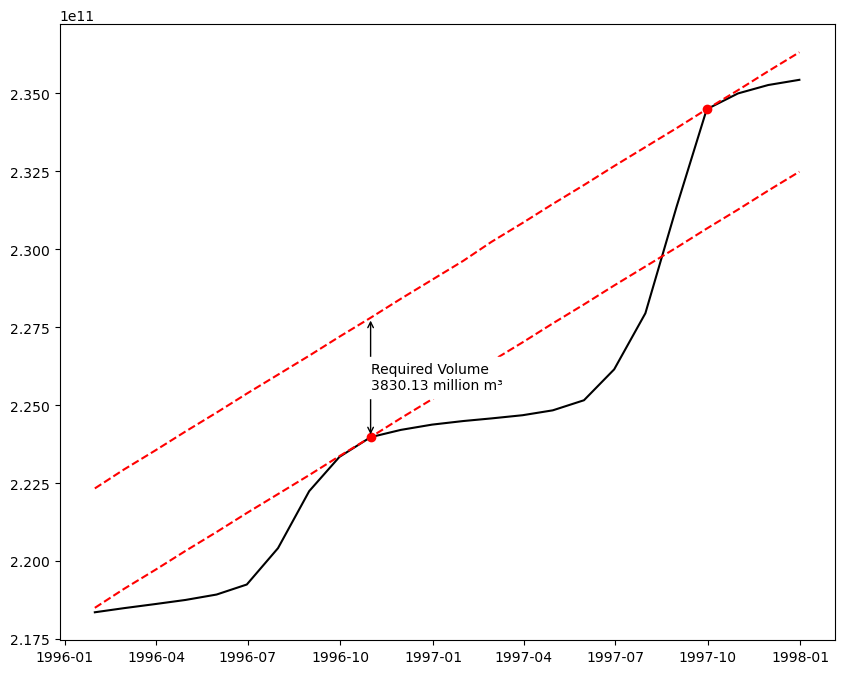

In [136]:
df_max = df.groupby(df.index.year).max()
df_max.drop(columns=["discharge", "cum_avg"], inplace=True)
df_max["diff"] = df_max["norm"].diff()

ye_1 = df_max["diff"].idxmax()
ye_0 = df_max["diff"].idxmax() - 1

diff_max = df_max["diff"].max()

print(ye_1, ye_0)
display(df_max.head())

df_red = df[(df.index.year >= ye_0) & (df.index.year <= ye_1)].copy()
df_red["max_y"] = df_red["norm"].groupby(df_red.index.year).transform('max')
df_red["min_y"] = df_red["norm"].groupby(df_red.index.year).transform('min')
df_red["upline"] = df_red["cum_avg"] + df_red["norm"].max()
df_red["loline"] = df_red["cum_avg"] + df_red[df_red.index.year == ye_0]["norm"].max()

display(df_max.head())

max_dates = df_red.groupby(df_red.index.year)['norm'].idxmax()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df_red.index, df_red["cum"], label="Normalized Discharge", color="black")
ax.plot(max_dates, df_red.loc[max_dates, "cum"], 'ro', label="Max Point")
ax.plot(df_red.index, df_red["upline"], 'r--', label="Max Line")
ax.plot(df_red.index, df_red["loline"], 'r--', label="Min Line")
ax.annotate(
    '', 
    xy=(max_dates.min(), df_red.loc[max_dates.min(), "upline"]),
    xytext=(max_dates.min(), df_red.loc[max_dates.min(), "loline"]),
    arrowprops=dict(arrowstyle='<->', color='black', lw=1)
)
ax.text(
    max_dates.min(), 
    (df_red.loc[max_dates.min(), "upline"] + df_red.loc[max_dates.min(), "loline"]) / 2,
    f'Required Volume\n{(df_red["upline"].max() - df_red["loline"].max())/1e6:.2f} million m³',
    color='black',
    fontsize=10,
    ha='left',
    va='center',
    backgroundcolor='white'
)

req_vol = df_red["upline"].max() - df_red["loline"].max()

print(f"Required Volume: {req_vol / 1e6:.2f} million cubic meters")
